In [1]:
from google.colab import files
uploaded = files.upload()

Saving acc_x.csv to acc_x.csv
Saving acc_y.csv to acc_y.csv
Saving acc_z.csv to acc_z.csv


In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

import os
import sys
import math
from scipy.fftpack import fft
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.colors as mcolors

In [4]:
data_x = pd.read_csv('acc_x.csv')
data_y = pd.read_csv('acc_y.csv')
data_z = pd.read_csv('acc_z.csv')

In [5]:
accelometer = pd.DataFrame()
accelometer['x'] = data_x
accelometer['y'] = data_y
accelometer['z'] = data_z

In [6]:
print(accelometer)

              x         y         z
0      0.011905  0.048193  9.804955
1      0.023810  0.048193  9.832613
2      0.023810  0.048193  9.832613
3      0.035714  0.060241  9.860152
4      0.011905  0.048193  9.832732
...         ...       ...       ...
30185 -0.023810 -0.012048  9.833692
30186 -0.023810 -0.012048  9.833692
30187 -0.023810 -0.012048  9.833692
30188 -0.023810 -0.012048  9.833692
30189 -0.023810 -0.048193  9.834053

[30190 rows x 3 columns]


In [77]:
# Defining constants 

number_of_signals = 3
length = 10000
filter_size = 71
fs = 512
cut_off = 1

In [78]:
def median_filter(data):

  filtered_data = np.zeros([length, number_of_signals])

  filtered_data[:, 0] = signal.medfilt(data['x'], filter_size)
  filtered_data[:, 1] = signal.medfilt(data['y'], filter_size)
  filtered_data[:, 2] = signal.medfilt(data['z'], filter_size)

  return filtered_data

In [95]:
def frequency_filter_xyz(data):
  lpf = signal.firwin(filter_size, cut_off/fs, window = 'hamming')

  filtered_data = np.zeros([length, number_of_signals])
  filtered_data[:, 0] = signal.convolve(data['x'], lpf, mode = 'same')
  filtered_data[:, 1] = signal.convolve(data['y'], lpf, mode = 'same')
  filtered_data[:, 2] = signal.convolve(data['z'], lpf, mode = 'same')
  
  return filtered_data

In [94]:
def frequency_filter(data):
  lpf = signal.firwin(filter_size, cut_off/fs, window = 'hamming')

  filtered_data = np.zeros([length, number_of_signals])

  for i in range(0, number_of_signals):
    filtered_data[:, i] = signal.convolve(data[:, i], lpf, mode = 'same')

  return filtered_data

In [81]:
def fft_plot_xyz(data, title):
  data_plot = np.zeros([length, number_of_signals])
  data_plot[:, 0] = np.abs(fft(data['x']))
  data_plot[:, 1] = np.abs(fft(data['y']))
  data_plot[:, 2] = np.abs(fft(data['z']))
  index = np.arange(int(length/2))/(int(length/2)/(fs/2))

  fig, ax = plt.subplots()

  labels = ['x','y','z']
  color_map = ['orange', 'cyan', 'pink']

  for i in range(number_of_signals):
    ax.plot(index, data_plot[0 : int(length/2), i], color_map[i], label = labels[i])

  ax.set_xlim([0, fs/2])
  ax.set_xlabel('Hz')
  ax.set_title('Frequency spectrum: ' + title) 
  ax.legend()

In [100]:
def fft_plot(data, title):
  data_plot = np.zeros([length, number_of_signals])
  for i in range(0, number_of_signals):
    data_plot[:, i] = np.abs(fft(data[:, i]))

  index = np.arange(int(length/2))/(int(length/2)/(fs/2))

  fig, ax = plt.subplots()

  labels = ['x','y','z']
  color_map = ['orange', 'c', 'pink']

  for i in range(number_of_signals):
    ax.plot(index, data_plot[0 : int(length/2), i], color_map[i], label = labels[i])
    
  ax.set_xlim([0, fs/2])
  ax.set_xlabel('Hz')
  ax.set_title('Frequency spectrum: ' + title) 
  ax.legend()

In [101]:
def plot_lines_xyz(data, title):
  fig, ax = plt.subplots()
  labels = ['x','y','z']
  color_map = ['orange', 'c', 'pink']

  index = np.arange(length)/fs
  ax.plot(index, data['x'], color_map[0], label = labels[0])
  ax.plot(index, data['y'], color_map[1], label = labels[1])
  ax.plot(index, data['z'], color_map[2], label = labels[2])

  ax.set_xlim([0, length/fs])
  ax.set_ylim([-15, 15])
  ax.set_xlabel('Time [s]')
  ax.set_ylabel('Position [mm]')
  ax.set_title(title)
  
  ax.legend()

In [98]:
def plot_lines(data, title):
  fig, ax = plt.subplots()

  labels = ['x','y','z']
  color_map = ['orange', 'c', 'pink']

  index = np.arange(length)/fs
  for i in range(0, number_of_signals):
    ax.plot(index, data[:, i], color_map[i], label = labels[i])

  ax.set_xlim([0, length/fs])
  ax.set_ylim([-15, 15])
  ax.set_xlabel('Time [s]')
  ax.set_ylabel('Position [mm]')
  ax.set_title(title)

  ax.legend()

In [85]:
def acc_integration_xyz(data):
  int_data = np.zeros(length, number_of_signals)
  int_data[:, 0] = trapezoid_integration(data['x'], length)
  int_data[:, 1] = trapezoid_integration(data['y'], length)
  int_data[:, 2] = trapezoid_integration(data['z'], length)

  return int_data

In [86]:
def acc_integration(data):
  int_data = np.zeros(length, number_of_signals)
  for i in range(0, number_of_signals):
    int_data[:, i] = trapezoid_integration(data[:, i], length)

  return int_data

In [87]:
def calibration(signal):
	increment = np.sum(np.clip(signal, a_min = 0, a_max = None))
	derivative = -1*np.sum(np.clip(signal, a_max = 0, a_min = None))

	if increment>derivative:
		beta_p = 1
		beta_n = increment/derivative
		c_signal = (beta_n - 1)*np.clip(signal, a_max = 0, a_min = None) + signal
	elif derivative>increment:
		beta_n = 1
		beta_p = derivative/increment
		c_signal = (beta_p - 1)*np.clip(signal, a_min = 0, a_max = None) + signal
	else:
		c_signal = signal

	return c_signal

In [88]:
def trapezoid_integration(input_signal):
  integral = np.zeros(length)
  c = 0

  for i, s in enumerate(input_signal):
    if i==0:
      integral[i] = c + input_signal[i]
    else:
      integral[i] = integral[i - 1] + input_signal[i]
      
  return integral

In [89]:
data = accelometer[10000 : 20000]

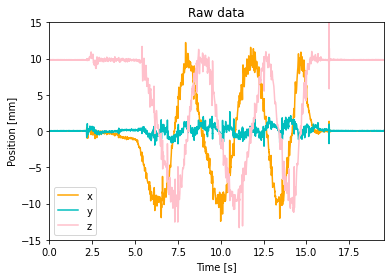

In [102]:
plot_lines_xyz(data, 'Raw data')

In [96]:
import time

t = time.time()
median_data = median_filter(data)
elapsed = time.time() - t
print(elapsed)
lpf_data = frequency_filter_xyz(data)
t = time.time()
combined_data = frequency_filter(median_data)
elapsed = time.time() - t
print(elapsed)

0.1670994758605957
0.0034143924713134766


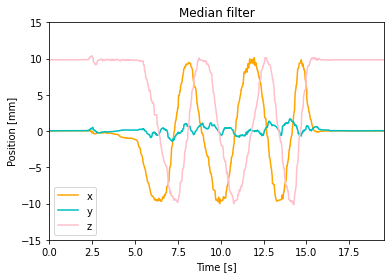

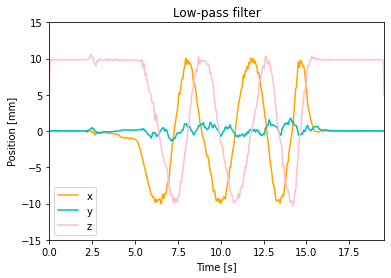

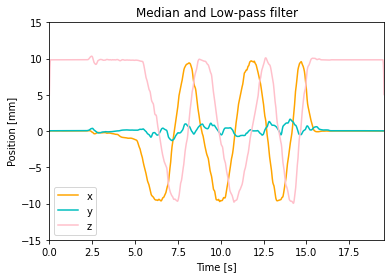

In [103]:
plot_lines(median_data, 'Median filter')
plot_lines(lpf_data, 'Low-pass filter')
plot_lines(combined_data, 'Median and Low-pass filter')

plt.show()